In [1]:
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

C:\Users\Uma\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data pre preprocessing 

In [4]:
# Google Drive file ID
file_id = "1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq" 
# Create the Google Drive download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the CSV file
output_path = "amazon_reviews.csv"
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq
From (redirected): https://drive.google.com/uc?id=1x9EhE6q0RDynrcEU4cmY7L3R8_Qcf9gq&confirm=t&uuid=3f4e608d-68e3-46bb-8b75-821824bffe05
To: C:\Users\Uma\Desktop\LAMBTON\TERM_2\NLP-\Assignment\amazon_reviews.csv
100%|███████████████████████████████████████████████████████████████████████████████| 157M/157M [00:07<00:00, 19.9MB/s]


'amazon_reviews.csv'

In [5]:
df = pd.read_csv(output_path)
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1580950175902,3,True
1,5.0,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,1604354586880,3,True
2,5.0,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1563966838905,0,True
3,4.0,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,1662258542725,7,True
4,1.0,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,1642722787262,0,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             494121 non-null  float64
 1   title              493996 non-null  object 
 2   text               493980 non-null  object 
 3   images             494121 non-null  object 
 4   asin               494121 non-null  object 
 5   parent_asin        494121 non-null  object 
 6   user_id            494121 non-null  object 
 7   timestamp          494121 non-null  int64  
 8   helpful_vote       494121 non-null  int64  
 9   verified_purchase  494121 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 34.4+ MB


In [7]:
# Check for missing values (nulls) in each column
null_values = df.isnull().sum()

# Display columns with null values and their counts
print(null_values[null_values > 0])

title    125
text     141
dtype: int64


In [8]:
# Percentage of missing values
null_percentage = (df.isnull().sum() / len(df)) * 100

# Display columns with missing values and their percentage
print(null_percentage[null_percentage > 0])

title    0.025297
text     0.028536
dtype: float64


In [9]:
# Drop rows with missing text or title
df = df.dropna(subset=['title', 'text'])

In [10]:
total_null_values = df.isnull().sum().sum()
total_null_values

0

In [11]:
# Convert Unix Timestamp to Readable Date
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

In [12]:
# Drop irrelevant columns
df = df.drop(columns=['images', 'asin', 'parent_asin', 'user_id',])

# columns names
df.columns

Index(['rating', 'title', 'text', 'timestamp', 'helpful_vote',
       'verified_purchase', 'date'],
      dtype='object')

In [13]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Check if the input is a valid string, return empty string if not
    if isinstance(text, str):
        text = text.lower()  # Lowercase
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stop words
        return ' '.join(tokens)
    else:
        return ''

# Apply the preprocessing to both 'title' and 'text'
df['clean_title'] = df['title'].apply(preprocess_text)
df['clean_text'] = df['text'].apply(preprocess_text)


In [14]:
# check null values
df.isnull().sum()

rating               0
title                0
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
date                 0
clean_title          0
clean_text           0
dtype: int64

In [15]:
# Drop the original 'title' and 'text' columns after preprocessing
df = df.drop(columns=['title', 'text'])

In [16]:
#Sentiment Labeling
def label_sentiment(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating >= 2.0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [17]:
# export to clean_data.csv
df.to_csv('clean_data.csv', index=False)

In [18]:
# Google Drive file ID
file_id = "1wFCuWmi6B33Qttx-wKlDdt5ityRdkMH4"
# Create the Google Drive download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the CSV file
output_path = "amazon_reviews_clean.csv"
gdown.download(download_url, output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1wFCuWmi6B33Qttx-wKlDdt5ityRdkMH4
To: C:\Users\Uma\Desktop\LAMBTON\TERM_2\NLP-\Assignment\amazon_reviews_clean.csv
100%|█████████████████████████████████████████████████████████████████████████████| 94.1M/94.1M [00:04<00:00, 20.0MB/s]


'amazon_reviews_clean.csv'

### Exploratory Data Analysis (EDA)

In [19]:
df.head(5)

,rating,timestamp,helpful_vote,verified_purchase,date,clean_title,clean_text,sentiment
0,4.0,1580950175902,3,True,2020-02-06 00:49:35.902,mg periodic table people mg magnesium,review clarify someone el review bc didnt unde...,positive
1,5.0,1604354586880,3,True,2020-11-02 22:03:06.880,save lanet using le plastic,love easy multitasking bleach tablet beat carr...,positive
2,5.0,1563966838905,0,True,2019-07-24 11:13:58.905,fantastic,suffering couple month heel pain plantar fasci...,positive
3,4.0,1662258542725,7,True,2022-09-04 02:29:02.725,hold water make bubble thats bought,cheap wanted massage function joke though come...,positive
4,1.0,1642722787262,0,True,2022-01-20 23:53:07.262,,didnt thing saying dont,negative


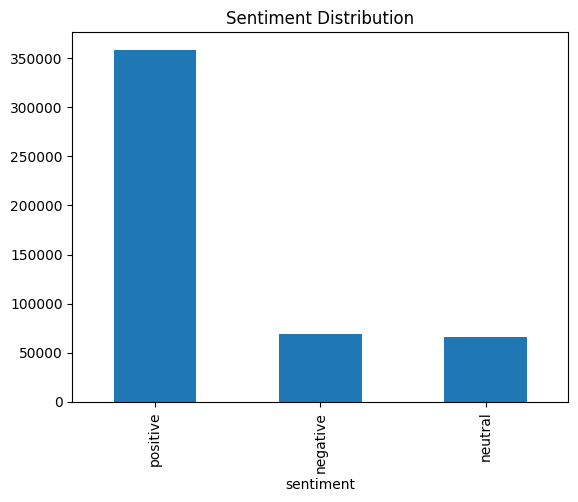

In [20]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

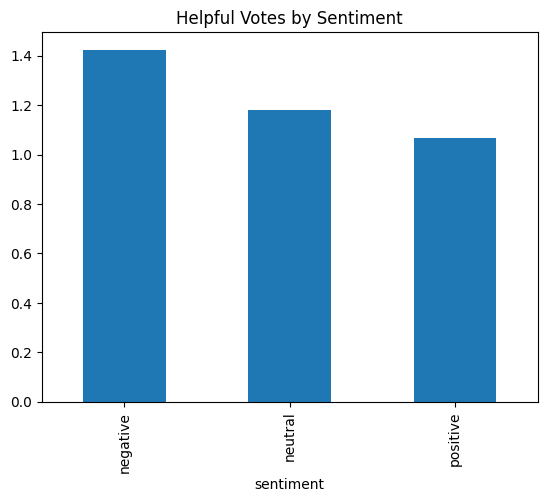

In [21]:
# Analyze if helpful votes have any correlation with positive or negative reviews.
df.groupby('sentiment')['helpful_vote'].mean().plot(kind='bar', title='Helpful Votes by Sentiment')
plt.show()

In [22]:
df[['rating', 'helpful_vote']].corr()

,rating,helpful_vote
rating,1.000000,-0.007774
helpful_vote,-0.007774,1.000000


In [23]:
# no correlation between rating and helpful votes drop the column helpful votes
df = df.drop(columns=['helpful_vote'])


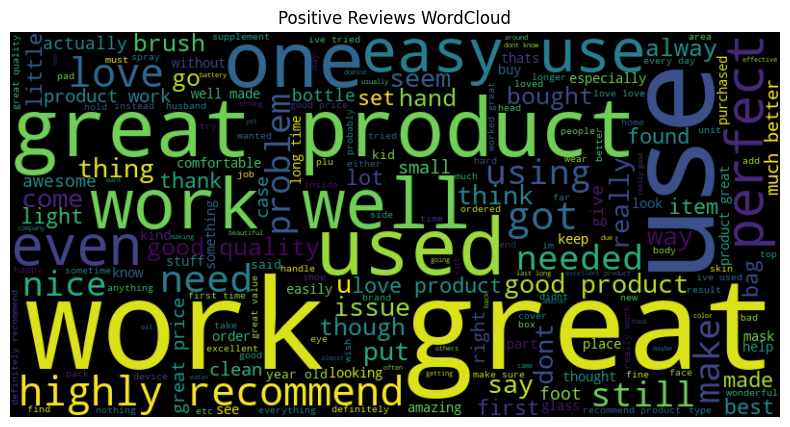

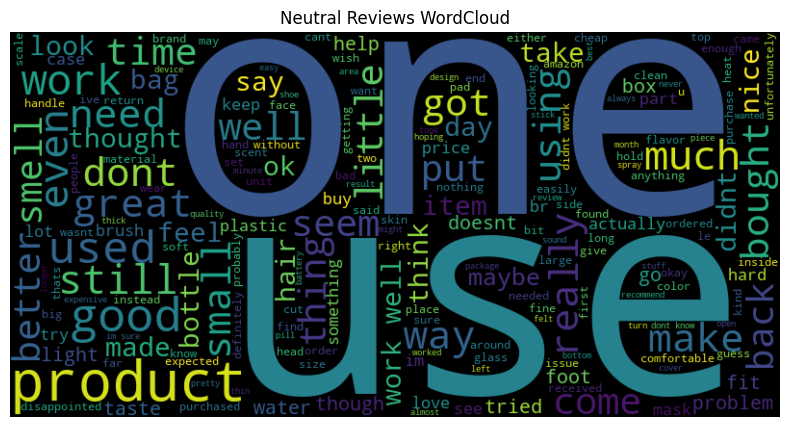

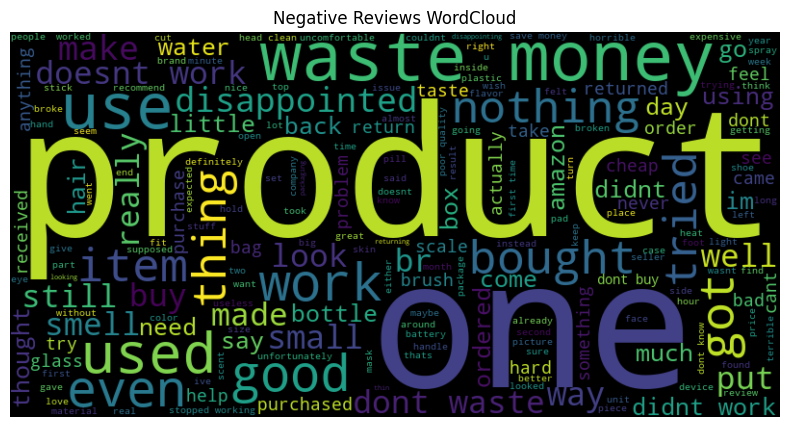

In [24]:
# Visualize common words in positive, neutral, and negative reviews using word clouds.


# Word cloud for positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_text'])
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews WordCloud')
plt.show()

# Word cloud for neutral reviews
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['clean_text'])
wordcloud_neutral = WordCloud(width=800, height=400).generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews WordCloud')
plt.show()

# Word cloud for negative reviews
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_text'])
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews WordCloud')
plt.show()

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

# Applying CountVectorizer method
vectorizer = CountVectorizer()

# Fit and transform the clean_text column to create the Bag of words model
bag_of_words = vectorizer.fit_transform(df['clean_text'])

# Getting the word feature names
words = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array
dense_matrix = bag_of_words.toarray()

# Create a DataFrame with words as columns and documents as rows
bow_df = pd.DataFrame(dense_matrix, columns=words)

# Display the Bag of Words DataFrame
print(bow_df.head())  

MemoryError: Unable to allocate 478. GiB for an array with shape (493901, 130024) and data type int64